# M1. URBAN MOVEMENT MODEL

En este reporte se mostrará una simulación del tráfico que se genera en una intersección de cuatro diferentes calles, con dos carriles cada una de ellas.

## Descripción del Reto

El tráfico es un problema que va en aumento debido al incremento en población de las ciudades, esto a su vez aparte de hacer perder tiempo a las personas en el congestionamiento que se genera por los semáforos, hace perder dinero y genera mayor contaminación al tener que utilizar más gasolina en un número de automóviles incrementado. Para dar solución a este problema se ha intentado ampliar la infraestructura con la finalidad de dar más opciones de rutas a los usuarios y de esta manera aliviar el tráfico. También se ha restringido en ciertas ciudades la circulación por días dependiendo del último dígito de la placa de los automóviles a pesar de que no en todos sus casos de aplicación resultó ser una medida eficiente ya que los usuarios en lugar de utilizar transporte público, adquirió un mayor número de automóviles con la finalidad de poder circular todos los días posibles. 


## ¿Cómo funciona el modelo?

Para la solución del reto se asume que cada calle será doble carril y de doble sentido, los únicos colores de semáforos que se utilizarán serán el verde y rojo. Todos los vehículos utilizarán las mismas magnitudes de aceleración, desaceleración para el frenado e iran a la máxima velocidad permitida de 60 km/h. Para visualizar la solución de congestión de tráfico se representará de forma gráfica el cruce de 2 calles, es decir de una intersección, en la que cada carro podrá tomar cualquier dirección aleatoriamente. Al representar una intersección existirán 4 semáforos, uno por cada entrada de carros a la misma y se asume que tan solo 1 de ellos podrá estar encendido a la vez.


In [24]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

from random import random
import math

In [25]:
class CarAgent(Agent):
    def __init__(self, unique_id, model, width, height, origin, destiny, light_pos, stop_distance, light_agent):
        super().__init__(unique_id, model)
        
        # Vector que representa la posición en 2D
        self.color = 'black'
        self.position = np.array((origin[0], origin[1]), dtype = np.float64)
        self.origin_road = np.array((origin[0], origin[1]), dtype = np.float64)
        self.destiny_road = destiny
        self.light_pos = light_pos
        self.stop_distance = stop_distance
        self.light_agent = light_agent
        self.light_agent.n_cars += 1
        self.crossed = None
        self.model = model
        
        # Vector que representa la velocidad
        if origin[0] > width / 2 - stop_distance * 2 and origin[0] < width / 2 + stop_distance * 2:
            if origin[1] < height / 2:
                self.speed = np.array([0, 10])
                self.acceleration = np.array([0, 10])
            else:
                self.speed = np.array([0, -10])
                self.acceleration = np.array([0, -10])
        else:
            if origin[0] < width / 2:
                self.speed = np.array([10, 0])
                self.acceleration = np.array([10, 0])
            else:
                self.speed = np.array([-10, 0])
                self.acceleration = np.array([-10, 0])
        
        
        # Límite de aceleración
        self.max_acceleration = 10
        
        # Límite de velocidad
        self.max_speed = 60
        
        # Distancia percibida como segura por el agente
        self.perception = 50
        
        self.width = width
        self.height = height

    def move(self):
        # Crossed traffic light
        if self.crossed != True and abs(np.linalg.norm(self.position - self.origin_road)) \
            > abs(np.linalg.norm(self.light_pos - self.origin_road)):
            # If marked as near to cross intersection
            if self.crossed == False:
                self.light_agent.crossing_cars -= 1
            self.crossed = True
            self.light_agent.n_cars -= 1

        # Reach light or pass light if on
        if self.light_agent.status == 1 or self.crossed == True or \
            abs(np.linalg.norm(self.position + self.speed - self.light_pos)) > self.stop_distance * 1.5:
            
            self.position += self.speed
            
            # Is near to cross the intersection. Tell traffic light that needs to pass
            if self.crossed == None and abs(np.linalg.norm(self.position + self.speed - self.light_pos)) > self.stop_distance * 2.2:
                self.crossed = False
                self.light_agent.crossing_cars += 1

            # Normalize speed limit
            self.speed += self.acceleration
            if np.linalg.norm(self.speed) > self.max_speed:
                self.speed = self.speed / np.linalg.norm(self.speed) * self.max_speed
        # If traffic light is off break until full stop
        else:
            if np.linalg.norm(self.speed) > 0:
                self.speed -= self.acceleration
                self.position += self.speed
            elif np.linalg.norm(self.speed) == 0:
                self.light_agent.sum_total_wait += 1
            else:
                self.speed *= 0
    
    def step(self):
        self.move()


In [26]:
class TrafficLightAgent(Agent):
    def __init__(self, unique_id, model, pos, max_on, max_off):
        super().__init__(unique_id, model)
        
        self.color = 'red'
        self.status = 0
        self.max_time_on = max_on
        self.max_time_off = max_off
        self.n_cars = 0
        self.crossing_cars = 0
        self.sum_total_wait = 0
        self.time_on = 0
        self.wait_off = 0
        self.position = np.array((pos[0], pos[1]), dtype = np.float64)
    
    def step(self):
        if self.status == 1:
            self.wait_off = 0
            self.time_on += 1
            if self.time_on >= self.max_time_on or self.crossing_cars == 0:
                self.status = 0
                self.color = 'red'
                self.time_on = 0
        else:
            if self.n_cars > 0:
                self.wait_off += 1



In [27]:
def get_agents(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

class UrbanMovementModel(Model):
    def __init__(self, spawn_cars, w, h, i_dist, max_on, max_off):
        self.num_agents = 0
        self.spawn_cars = spawn_cars
        self.width = w
        self.height = h
        self.schedule = RandomActivation(self)
        self.i_dist = i_dist
        self.max_on = max_on
        self.max_off = max_off
        self.actual_light = None
        self.delay_next_light = 0
        
        # (carril, semáforo, [carriles destino])
        self.intersection = [(1, 1, [8, 12]), (2, 1, [3, 7]), (5, 2, [12, 16]), (6, 2, [7, 11]),
                            (9, 3, [4, 16]), (10, 3, [11, 15]), (13, 4, [4, 8]), (14, 4, [3, 15])]

        
        self.road_pos = [[w / 2 + i_dist / 8, 0], [w / 2 + i_dist / 8 * 3, 0],
                        [w, h / 2 - i_dist / 8 * 3], [w, h / 2 - i_dist / 8],
                        [w, h / 2 + i_dist / 8], [w, h / 2 + i_dist / 8 * 3],
                        [w / 2 + i_dist / 8 * 3, h], [w / 2 + i_dist / 8, h],
                        [w / 2 - i_dist / 8, h], [w / 2 - i_dist / 8 * 3, h],
                        [0, h / 2 + i_dist / 8 * 3], [0, h / 2 + i_dist / 8],
                        [0, h / 2 - i_dist / 8], [0, h / 2 - i_dist / 8 * 3],
                        [w / 2 - i_dist / 8 * 3, 0], [w / 2 - i_dist / 8, 0]]

        self.light_pos = [[w / 2 + i_dist / 4, h / 2 - i_dist / 2],
                        [w / 2 + i_dist / 2, h / 2 + i_dist / 4],
                        [w / 2 - i_dist / 4, h / 2 + i_dist / 2],
                        [w / 2 - i_dist / 2, h / 2 - i_dist / 4]]

        self.light_agents = []

        self.time_for_spawn = np.array([0, 0, 0, 0, 0, 0, 0, 0])
        
        self.createLights()

        self.createAgents()

        self.datacollector = DataCollector(model_reporters = {"Agents" : get_agents})
    

    def createLights(self):
        for i in range(len(self.light_pos)):
            light = TrafficLightAgent(self.num_agents, self, self.light_pos[i], self.max_on, self.max_off)
            self.num_agents += 1
            self.light_agents.append(light)
            self.schedule.add(light)
    

    def createAgents(self):
        for i in range(len(self.intersection)):
            if self.time_for_spawn[i] <= 0 and random() <= self.spawn_cars:
                self.time_for_spawn[i] = 3
                (road, light, dest) = self.intersection[i]
                j = np.random.randint(len(dest))
                car = CarAgent(self.num_agents, self, self.width, self.height, self.road_pos[road - 1], 
                                dest[j], self.light_pos[light - 1], self.i_dist / 4, self.light_agents[light - 1])
                self.num_agents += 1
                self.schedule.add(car)


    def change_light(self):

        if self.actual_light == None and self.delay_next_light <= 0:
            best_light = None
            best_priority = 0
            for i in range(len(self.light_agents)):
                actual_light = self.light_agents[i]
                priority = 0
                if actual_light.wait_off >= actual_light.max_time_off:
                    priority += (actual_light.wait_off * 5)
                if actual_light.crossing_cars > 0:
                    priority += math.ceil(actual_light.sum_total_wait / actual_light.crossing_cars)
                
                if priority > best_priority:
                    best_priority = priority
                    best_light = i

            if best_light != None:
                self.light_agents[best_light].status = 1
                self.light_agents[best_light].color = 'green'
                self.actual_light = best_light
        
        elif self.actual_light != None and self.light_agents[self.actual_light].status == 0:
            self.actual_light = None
            self.delay_next_light = 4
        
        else:
            self.delay_next_light -= 1


    def step(self):
        self.createAgents()
        self.change_light()
        self.time_for_spawn -= 1
        self.datacollector.collect(self)
        self.schedule.step()

In [28]:
WIDTH = 5000
HEIGHT = 2500
INTERSECT_DIST = 400
PROB_SPAWN = 0.1
MAX_TIME_ON = 20
MAX_TIME_OFF = 75
MAX_ITERATIONS = 300

model = UrbanMovementModel(PROB_SPAWN, WIDTH, HEIGHT, INTERSECT_DIST, MAX_TIME_ON, MAX_TIME_OFF)
for i in range(MAX_ITERATIONS):
    model.step()
    

In [29]:
all_positions = model.datacollector.get_model_vars_dataframe()

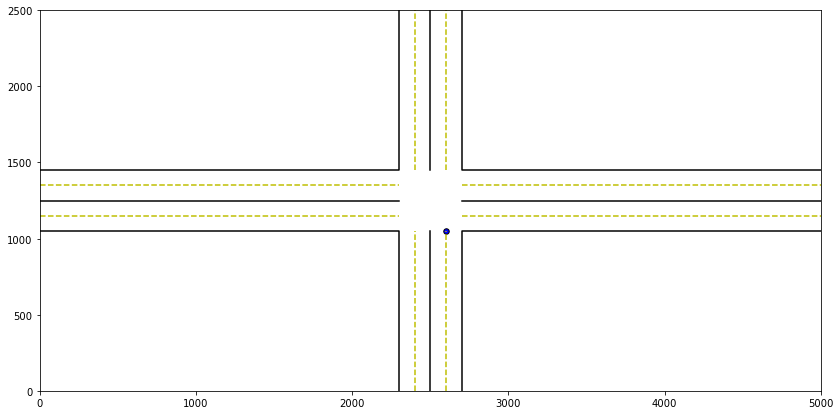

In [30]:
fig, ax = plt.subplots(figsize=(14,7))

# El segundo 0 es el diccionario que estoy manejando; después se utiliza el slice para tomar las x de los vectores de 2.
scatter = ax.scatter(all_positions.iloc[0][0][:,0][0], all_positions.iloc[0][0][:,1][0], 
                s=30, cmap="jet", edgecolor = "k", facecolor = 'blue')

# Corners
x1 = [0, WIDTH / 2 - INTERSECT_DIST / 2, WIDTH / 2 - INTERSECT_DIST / 2]
y1 = [HEIGHT / 2 - INTERSECT_DIST / 2, HEIGHT / 2 - INTERSECT_DIST / 2, 0]
plt.plot(x1, y1, color='black')
y2 = [HEIGHT / 2 + INTERSECT_DIST / 2, HEIGHT / 2 + INTERSECT_DIST / 2, HEIGHT]
plt.plot(x1, y2, color='black')
x2 = [WIDTH, WIDTH / 2 + INTERSECT_DIST / 2, WIDTH / 2 + INTERSECT_DIST / 2]
plt.plot(x2, y2, color='black')
plt.plot(x2, y1, color='black')

# Izquierda
xlane = [0, WIDTH / 2 - INTERSECT_DIST / 2]
ylane = [HEIGHT / 2, HEIGHT / 2]
plt.plot(xlane, ylane, color='black')
ylane = [HEIGHT / 2 - INTERSECT_DIST / 4, HEIGHT / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
ylane = [HEIGHT / 2 + INTERSECT_DIST / 4, HEIGHT / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
# Derecha
xlane = [WIDTH / 2 + INTERSECT_DIST / 2, WIDTH]
ylane = [HEIGHT / 2, HEIGHT / 2]
plt.plot(xlane, ylane, color='black')
ylane = [HEIGHT / 2 - INTERSECT_DIST / 4, HEIGHT / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
ylane = [HEIGHT / 2 + INTERSECT_DIST / 4, HEIGHT / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
# Abajo
xlane = [WIDTH / 2, WIDTH / 2]
ylane = [0, HEIGHT / 2 - INTERSECT_DIST / 2]
plt.plot(xlane, ylane, color='black')
xlane = [WIDTH / 2 - INTERSECT_DIST / 4, WIDTH / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
xlane = [WIDTH / 2 + INTERSECT_DIST / 4, WIDTH / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
# Arriba
xlane = [WIDTH / 2, WIDTH / 2]
ylane = [HEIGHT / 2 + INTERSECT_DIST / 2, HEIGHT]
plt.plot(xlane, ylane, color='black')
xlane = [WIDTH / 2 - INTERSECT_DIST / 4, WIDTH / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
xlane = [WIDTH / 2 + INTERSECT_DIST / 4, WIDTH / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')

ax.axis([0, WIDTH, 0, HEIGHT])
def update(frame_number):
    # Arreglo de pares x, y.
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    return scatter

anim = animation.FuncAnimation(fig, update, frames = MAX_ITERATIONS)

In [31]:
anim